Class Names: ['Beagle', 'Boxer', 'Bulldog', 'Dachshund', 'German_Shepherd', 'Golden_Retriever', 'Labrador_Retriever', 'Poodle', 'Rottweiler', 'Yorkshire_Terrier']


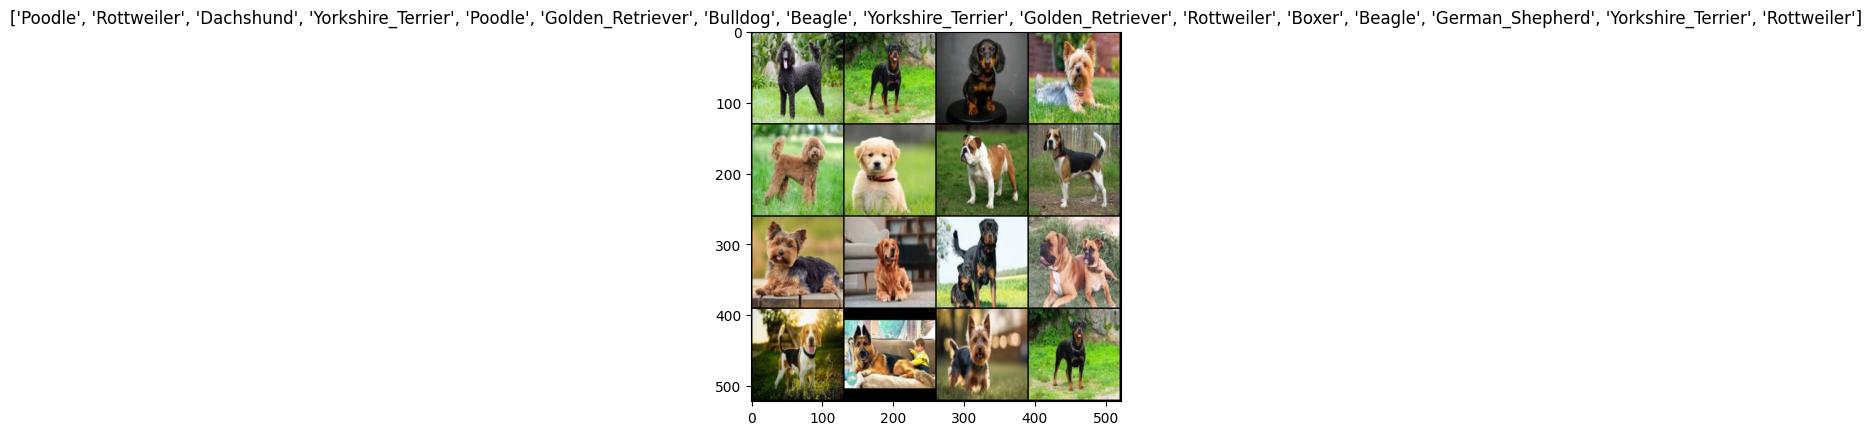

Image Dimensions: torch.Size([16, 3, 128, 128])


In [8]:
import torch
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

# Define transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resizing all images to 128x128
    transforms.ToTensor(),          # Convert images to tensors
])

# Load the dataset
dataset = datasets.ImageFolder(root='dog-breeds', transform=transform)

# Display class names
class_names = dataset.classes
print("Class Names:", class_names)

# Create a DataLoader to iterate over the dataset
data_loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

# Function to show images in a grid
def show_images(images, labels):
    images = make_grid(images, nrow=4)
    npimg = images.numpy().transpose((1, 2, 0))
    plt.imshow(npimg)
    plt.title([class_names[label] for label in labels])
    plt.show()

# Get a batch of images and labels
images, labels = next(iter(data_loader))

# Show images and labels
show_images(images, labels)

# Print the dimensions of the images
print("Image Dimensions:", images.shape)  # Should be (Batch Size, Channels, Height, Width)


In [9]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 32 * 32)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model, loss function, and optimizer
num_classes = len(class_names)
model = SimpleCNN(num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
epochs = 5
for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    # Use TQDM for progress tracking
    for images, labels in tqdm(data_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")

print("Training Complete!")

torch.save(model.state_dict(), 'classifier_cnn_model.pt')

Epoch 1/5: 100%|██████████| 61/61 [00:01<00:00, 33.83it/s]


Epoch [1/5], Loss: 2.1452, Accuracy: 38.16%


Epoch 2/5: 100%|██████████| 61/61 [00:01<00:00, 34.38it/s]


Epoch [2/5], Loss: 0.2629, Accuracy: 93.59%


Epoch 3/5: 100%|██████████| 61/61 [00:01<00:00, 34.69it/s]


Epoch [3/5], Loss: 0.0156, Accuracy: 99.90%


Epoch 4/5: 100%|██████████| 61/61 [00:01<00:00, 33.27it/s]


Epoch [4/5], Loss: 0.0014, Accuracy: 100.00%


Epoch 5/5: 100%|██████████| 61/61 [00:01<00:00, 32.68it/s]


Epoch [5/5], Loss: 0.0004, Accuracy: 100.00%
Training Complete!


Classification Report:
                    precision    recall  f1-score   support

            Beagle       1.00      1.00      1.00       100
             Boxer       1.00      1.00      1.00       100
           Bulldog       1.00      1.00      1.00       100
         Dachshund       1.00      1.00      1.00        96
   German_Shepherd       1.00      1.00      1.00        96
  Golden_Retriever       1.00      1.00      1.00        91
Labrador_Retriever       1.00      1.00      1.00        95
            Poodle       1.00      1.00      1.00       100
        Rottweiler       1.00      1.00      1.00        89
 Yorkshire_Terrier       1.00      1.00      1.00       100

          accuracy                           1.00       967
         macro avg       1.00      1.00      1.00       967
      weighted avg       1.00      1.00      1.00       967



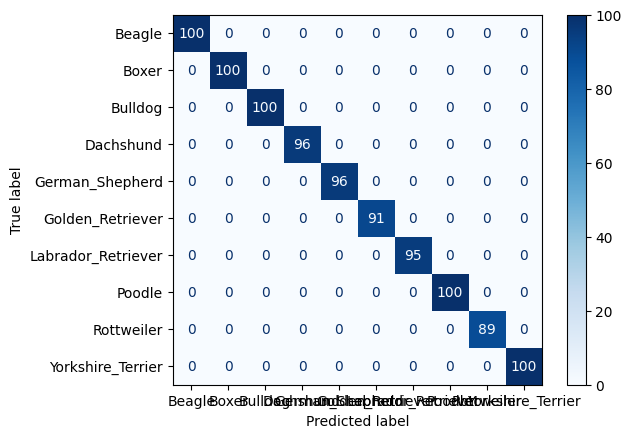

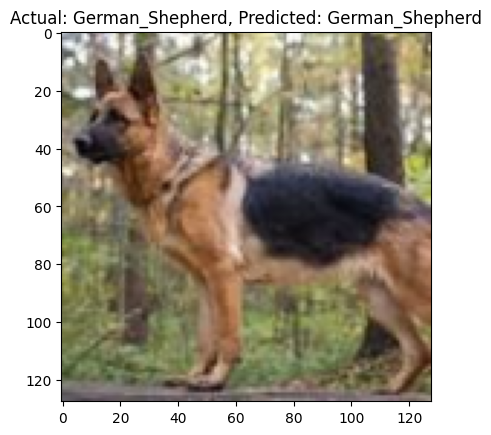

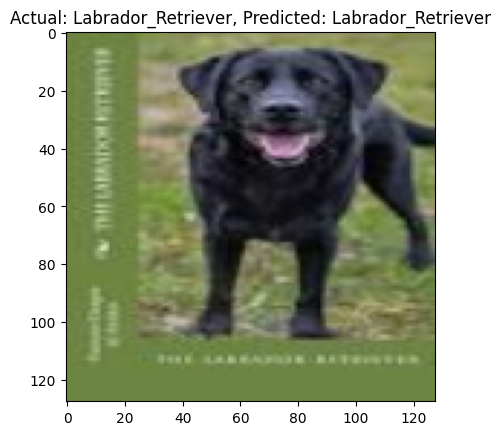

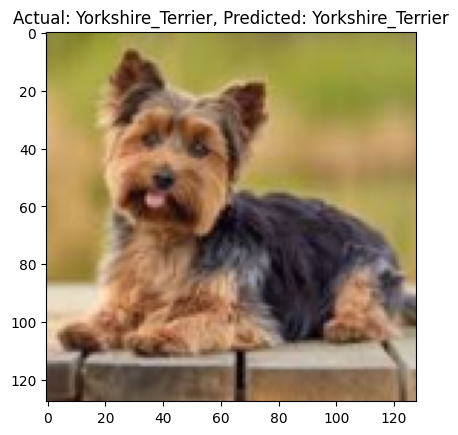

In [10]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import random

# Function to test the model and generate the required plots
def test_model(model, data_loader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    # Show actual class and predicted class for 3 random images
    indices = random.sample(range(len(dataset)), 3)
    for i in indices:
        image, label = dataset[i]
        image = image.unsqueeze(0).to(device)
        output = model(image)
        _, predicted = torch.max(output.data, 1)
        predicted_label = predicted.item()
        plt.imshow(image.cpu().squeeze().permute(1, 2, 0))
        plt.title(f"Actual: {class_names[label]}, Predicted: {class_names[predicted_label]}")
        plt.show()

# Test the model
test_model(model, data_loader)


In [11]:
import torch
import torch.nn.functional as F
import numpy as np
from scipy.optimize import differential_evolution
from tqdm import tqdm

# Define the one-pixel attack function
def one_pixel_attack(image, label, model, bounds, maxiter=100):
    def perturb_pixel(pixel):
        perturbed_image = image.clone().detach()
        perturbed_image[0, :, int(pixel[0]), int(pixel[1])] = torch.tensor(pixel[2:], device=image.device)
        output = model(perturbed_image)
        loss = F.cross_entropy(output, torch.tensor([label], device=image.device))  # Correct label to be a 1D tensor with a single value
        return loss.item()
    
    result = differential_evolution(perturb_pixel, bounds=bounds, maxiter=maxiter)
    return result.x  # Returns the best pixel found

bounds = [(0, 127), (0, 127), (0, 1), (0, 1), (0, 1)]  

# Load the trained model
model.eval()

# Prepare the datasets
dog_breeds_attacked = []
patch_data = []

for i, (image, label) in tqdm(enumerate(dataset), total=len(dataset), desc="Creating datasets"):
    image = image.unsqueeze(0).to(device)
    
    pixel = one_pixel_attack(image, label, model, bounds)
    attacked_image = image.clone().detach()
    attacked_image[0, :, int(pixel[0]), int(pixel[1])] = torch.tensor(pixel[2:], device=image.device)
    
    dog_breeds_attacked.append((attacked_image.cpu().squeeze(), label))
    
    patch_size = 16
    for row in range(0, 128, patch_size):
        for col in range(0, 128, patch_size):
            patch = attacked_image[:, :, row:row+patch_size, col:col+patch_size]
            patch_id = f"[{i}][{row//patch_size * 8 + col//patch_size}]"
            attacked_or_not = 1 if (row <= pixel[0] < row + patch_size and col <= pixel[1] < col + patch_size) else 0
            patch_data.append((patch.cpu().squeeze(), patch_id, attacked_or_not))


Creating datasets:   1%|          | 7/967 [01:01<2:19:55,  8.75s/it]


KeyboardInterrupt: 

In [ ]:
# Convert to torch tensor
dog_breeds_attacked = [(img, lbl) for img, lbl in dog_breeds_attacked]
patch_data = [(patch, patch_id, attacked_or_not) for patch, patch_id, attacked_or_not in patch_data]

# Save datasets
torch.save(dog_breeds_attacked, 'dog-breeds-attacked.pt')
torch.save(patch_data, 'Patch-data.pt')


Testing attacked dataset: 100%|██████████| 967/967 [00:01<00:00, 487.09it/s]


Accuracy: 100.00%
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100
           2       1.00      1.00      1.00       100
           3       1.00      1.00      1.00        96
           4       1.00      1.00      1.00        96
           5       1.00      1.00      1.00        91
           6       1.00      1.00      1.00        95
           7       1.00      1.00      1.00       100
           8       1.00      1.00      1.00        89
           9       1.00      1.00      1.00       100

    accuracy                           1.00       967
   macro avg       1.00      1.00      1.00       967
weighted avg       1.00      1.00      1.00       967



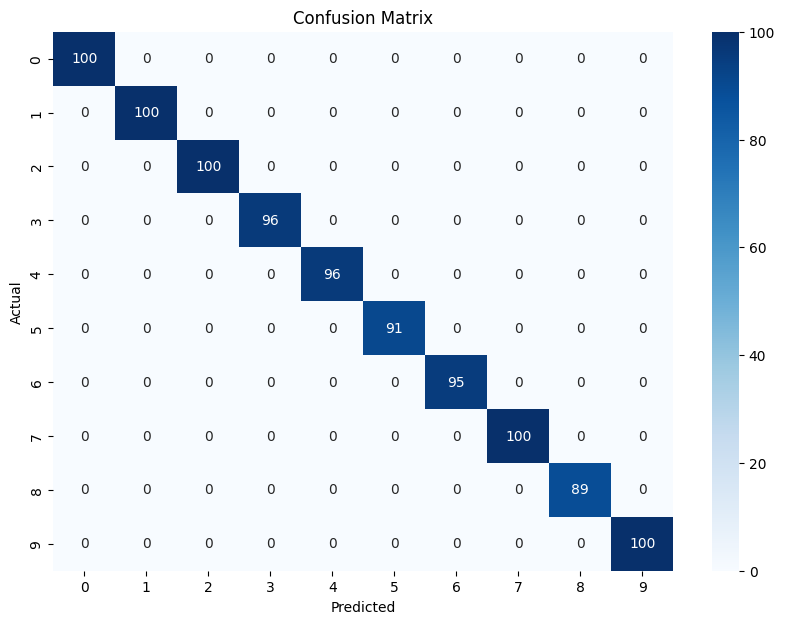

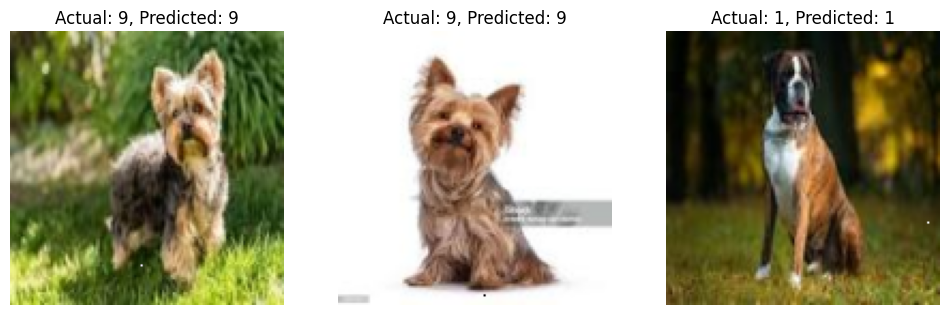

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Load the attacked dataset
dog_breeds_attacked = torch.load('dog-breeds-attacked.pt')

# Set model to evaluation mode
model.eval()

# Initialize variables for accuracy calculation
all_preds = []
all_labels = []
loss_fn = torch.nn.CrossEntropyLoss()

# Test the attacked dataset
with torch.no_grad():
    for attacked_image, label in tqdm(dog_breeds_attacked, desc="Testing attacked dataset"):
        attacked_image = attacked_image.unsqueeze(0).to(device)  # Add batch dimension
        label = torch.tensor(label).to(device)  # Convert label to tensor
        
        output = model(attacked_image)
        loss = loss_fn(output, label.unsqueeze(0))  # Compute loss
        
        _, predicted = torch.max(output, 1)  # Get predicted class
        
        all_preds.append(predicted.item())
        all_labels.append(label.item())

# Calculate accuracy
accuracy = np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Display classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds))

# Plot confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(all_labels), yticklabels=np.unique(all_labels))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Show actual and predicted classes for 3 random images
random_indices = np.random.choice(len(dog_breeds_attacked), size=3, replace=False)

plt.figure(figsize=(12, 4))
for i, idx in enumerate(random_indices):
    attacked_image, label = dog_breeds_attacked[idx]
    attacked_image = attacked_image.permute(1, 2, 0)  # Rearrange for plotting
    attacked_image = attacked_image.numpy()

    # Get prediction
    predicted = all_preds[idx]
    
    plt.subplot(1, 3, i + 1)
    plt.imshow(attacked_image)
    plt.title(f'Actual: {label}, Predicted: {predicted}')
    plt.axis('off')

plt.show()


Class Label: 0


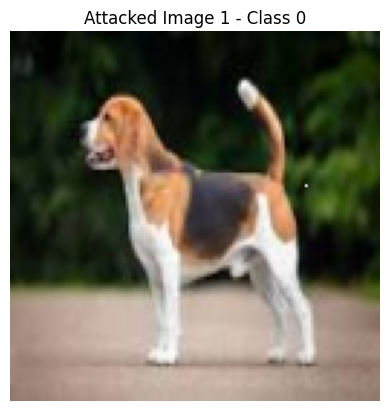

Class Label: 0


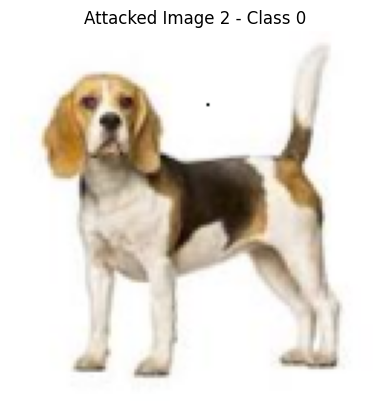

Class Label: 0


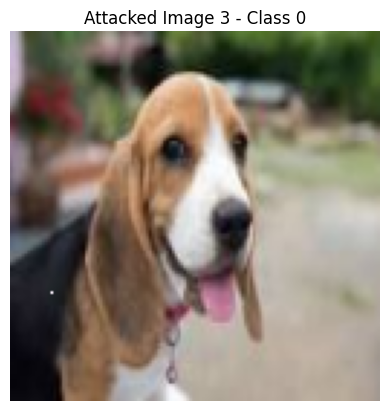

torch.Size([3, 128, 128])

In [ ]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# Load the attacked dataset
dog_breeds_attacked = torch.load('dog-breeds-attacked.pt')

# Function to display an image
def show_image(image_tensor, title=""):
    image = image_tensor.squeeze(0)  # Remove the batch dimension
    image = transforms.ToPILImage()(image)  # Convert tensor to PIL image
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Preview a few images from the attacked dataset
for i in range(3):  # Change the range to see more examples
    attacked_image, label = dog_breeds_attacked[i]
    print(f"Class Label: {label}")
    show_image(attacked_image, title=f"Attacked Image {i+1} - Class {label}")
attacked_image.shape

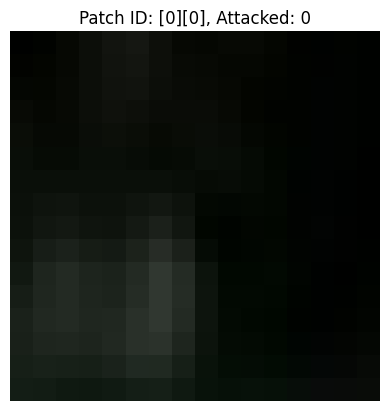

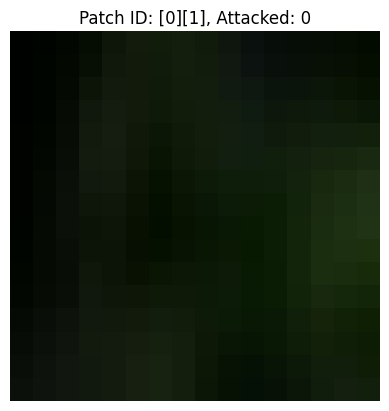

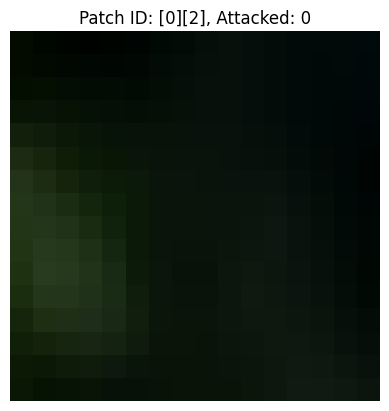

In [ ]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# Load the patch dataset
patch_data = torch.load('Patch-data.pt')

# Function to display a patch
def show_patch(patch_tensor, patch_id, attacked_or_not):
    patch = patch_tensor.squeeze(0)  # Remove the batch dimension
    patch = transforms.ToPILImage()(patch)  # Convert tensor to PIL image
    plt.imshow(patch)
    title = f"Patch ID: {patch_id}, Attacked: {attacked_or_not}"
    plt.title(title)
    plt.axis('off')
    plt.show()

# Preview a few patches from the patch dataset
for i in range(3):  # Change the range to see more examples
    patch_tensor, patch_id, attacked_or_not = patch_data[i]
    show_patch(patch_tensor, patch_id, attacked_or_not)
patch_tensor, _, _ = patch_data[0]


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import torch.nn.functional as F


# Define the CNN model
class PatchCNN(nn.Module):
    def __init__(self):
        super(PatchCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 4 * 4, 128)  # Assuming 16x16 input patches
        self.fc2 = nn.Linear(128, 2)  # Binary classification

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # No activation here; use softmax in the loss function
        return x

class PatchDataset(Dataset):
    def __init__(self, patch_data):
        self.patches = patch_data

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        patch, patch_id, attacked_or_not = self.patches[idx]
        return patch.float(), attacked_or_not  # Return the patch and label

# Load the patch data
patch_data = torch.load('Patch-data.pt')
dataset = PatchDataset(patch_data)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize the model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = PatchCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training parameters
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    with tqdm(total=len(data_loader), desc=f'Epoch {epoch + 1}/{num_epochs}') as pbar:
        for patches, labels in data_loader:
            patches, labels = patches.to(device), labels.to(device)

            # Forward pass
            outputs = model(patches)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate running loss and accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            pbar.set_postfix(loss=running_loss / (pbar.n + 1), accuracy=correct / total)
            pbar.update(1)

    # Print average loss and accuracy for the epoch
    avg_loss = running_loss / len(data_loader)
    accuracy = correct / total
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy * 100:.2f}%')




Epoch 1/10: 100%|██████████| 1934/1934 [00:07<00:00, 249.08it/s, accuracy=0.992, loss=0.0378]


Epoch [1/10], Loss: 0.0378, Accuracy: 99.22%


Epoch 2/10: 100%|██████████| 1934/1934 [00:07<00:00, 241.97it/s, accuracy=0.999, loss=0.00688]


Epoch [2/10], Loss: 0.0069, Accuracy: 99.89%


Epoch 3/10: 100%|██████████| 1934/1934 [00:07<00:00, 243.43it/s, accuracy=0.999, loss=0.0057] 


Epoch [3/10], Loss: 0.0057, Accuracy: 99.91%


Epoch 4/10: 100%|██████████| 1934/1934 [00:08<00:00, 232.09it/s, accuracy=0.999, loss=0.00459]


Epoch [4/10], Loss: 0.0046, Accuracy: 99.93%


Epoch 5/10: 100%|██████████| 1934/1934 [00:08<00:00, 237.98it/s, accuracy=0.999, loss=0.00404]


Epoch [5/10], Loss: 0.0040, Accuracy: 99.93%


Epoch 6/10: 100%|██████████| 1934/1934 [00:07<00:00, 242.12it/s, accuracy=0.999, loss=0.00331]


Epoch [6/10], Loss: 0.0033, Accuracy: 99.95%


Epoch 7/10: 100%|██████████| 1934/1934 [00:08<00:00, 238.33it/s, accuracy=0.999, loss=0.00315]


Epoch [7/10], Loss: 0.0031, Accuracy: 99.95%


Epoch 8/10: 100%|██████████| 1934/1934 [00:09<00:00, 203.68it/s, accuracy=1, loss=0.00291]    


Epoch [8/10], Loss: 0.0029, Accuracy: 99.95%


Epoch 9/10: 100%|██████████| 1934/1934 [00:10<00:00, 178.04it/s, accuracy=1, loss=0.00302]    


Epoch [9/10], Loss: 0.0030, Accuracy: 99.95%


Epoch 10/10: 100%|██████████| 1934/1934 [00:10<00:00, 188.09it/s, accuracy=1, loss=0.00245]    

Epoch [10/10], Loss: 0.0025, Accuracy: 99.96%


In [ ]:
torch.save(model.state_dict(), 'patchCNN.pt')

In [ ]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

# Load the attacked dataset
dog_breeds_attacked = torch.load('dog-breeds-attacked.pt')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the trained model for patch prediction
class PatchCNN(nn.Module):
    # (Assuming the same architecture as defined earlier)
    def __init__(self):
        super(PatchCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 2)  # Binary classification

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize model
model = PatchCNN().to(device)
model.load_state_dict(torch.load('patchCNN.pt'))  # Load your trained model weights
model.eval()

# Repair mechanism
def repair_image(image):
    patch_size = 16
    patches = []
    patch_probs = []

    # Divide the image into patches
    for row in range(0, 128, patch_size):
        for col in range(0, 128, patch_size):
            patch = image[:, :, row:row + patch_size, col:col + patch_size]
            patches.append(patch)

    # Process each patch
    with torch.no_grad():
        for patch in tqdm(patches, desc="Processing patches"):
            patch = patch.to(device)
            output = model(patch)
            prob = F.softmax(output, dim=1)  # Get probabilities
            patch_probs.append(prob[0][1].item())  # Probability of being attacked

    # Find the index of the patch with the highest probability
    attacked_patch_index = patch_probs.index(max(patch_probs))

    # Repair the identified attacked patch (simple example: use average of surrounding pixels)
    row = (attacked_patch_index // 4) * patch_size
    col = (attacked_patch_index % 4) * patch_size
    # Average neighboring patches to repair
    surrounding_patches = []

    # Collect surrounding patches (with boundary checks)
    for i in range(max(0, attacked_patch_index - 5), min(len(patches), attacked_patch_index + 3)):
        if i != attacked_patch_index:
            surrounding_patches.append(patches[i])

    # Create a repaired patch by averaging surrounding patches
    if surrounding_patches:
        repaired_patch = torch.mean(torch.cat(surrounding_patches), dim=0, keepdim=True)
        # Replace the attacked patch in the original image
        image[:, :, row:row + patch_size, col:col + patch_size] = repaired_patch

    return image

# Main loop to repair images in the attacked dataset
repaired_images = []

for attacked_image, label in tqdm(dog_breeds_attacked, desc="Repairing images"):
    attacked_image = attacked_image.unsqueeze(0).to(device)  # Add batch dimension
    repaired_image = repair_image(attacked_image)
    repaired_images.append((repaired_image.cpu(), label))

# Save or use repaired_images as needed
torch.save(repaired_images, 'repaired_images.pt')


Repairing images:   0%|          | 2/967 [00:00<01:31, 10.50it/s]


RuntimeError: The expanded size of the tensor (0) must match the existing size (16) at non-singleton dimension 2.  Target sizes: [1, 3, 0, 16].  Tensor sizes: [3, 16, 16]